In [1]:
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pyarrow.feather as feather
import gc
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.preprocessing import StandardScaler

BIG_NUMBER = 1e25
SMALL_NUMBER = 1/BIG_NUMBER
POOL_FEE = .0005


In [7]:
directory = "data"

In [11]:



df_mint = feather.read_feather(directory+'/'+'mint')
df_burn = feather.read_feather(directory+'/'+'burn')

df_swap = feather.read_feather(directory+'/'+'split_swaps/swap_ab')
# df_swap2 = feather.read_feather(directory+'/'+'split_swaps/swap_ab')



df_mint["Type"] = "Mint"
df_burn["Type"] = "Burn"
df_swap["Type"] = "Swap"
df_burn.loc[:, 'liquidity'] *= -1

num_swap_files = 3
# alph = "abcdefghijklmnopqrstuvwxyz"
alph = "bcdefghijklmnopqrstuvwxyz"


for i in range(1,1+num_swap_files):

    dir = directory+'/'+'split_swaps/swap_a' + alph[i]
    df_swap_add = feather.read_feather(dir)
    df_swap_add["Type"] = "Swap"
    df_swap = pd.concat([df_swap, df_swap_add], axis=0)


df_orig = pd.concat([df_swap, df_mint, df_burn], ignore_index=True).sort_values(['blockNumber', 'logIndex']).reset_index(drop=True)


df_orig['rangeLow'] = 1 / ( 1.0001**df_orig['upperTick'] / (10**12) )
df_orig['rangeHigh'] =  1 / ( 1.0001**df_orig['lowerTick'] / (10**12) )

df = df_orig[(df_orig.timestamp <  df_swap["timestamp"].max()) & (df_orig.timestamp >  df_swap["timestamp"].min())]
# del df_mint, df_burn
del df_mint, df_burn, df_orig


gc.collect()
df['price'].ffill(inplace=True)
df['rangeLow'].ffill(inplace=True)
df['rangeHigh'].ffill(inplace=True)
df.loc[df.Type == 'swap', 'liquidity'] = 0


# Resample into 5 minute intervals
# df = df.resample('5T', on="timestamp").mean()

# remove any NAs
df_mask = df[["rangeLow", "rangeHigh"]].isna().any(axis=1)
df  = df[~df_mask]
df.reset_index(drop=True, inplace=True)


dd1= df.pivot_table(index=df.index, columns=['rangeLow'], values='liquidity', fill_value=0).cumsum() #Group together liquidity with same rangeLow, c
dd2 = df.pivot_table(index=df.index, columns=['rangeHigh'], values='liquidity', fill_value=0).cumsum()
dd3 = dd1.subtract(dd2, fill_value=0) # Subtract range highs and lows to only get net liquidity delta between each tick value
del dd1, dd2
gc.collect()

0

In [12]:
histogram = dd3.cumsum(axis=1)

# Resample on histogram directly instead of result_df

# histogram["timestamp"] = df["timestamp"]
# histogram["price"] = df["price"]

# histogram = histogram.resample('0.5T', on="timestamp").mean().ffill()
# price_resampled = histogram["price"] # maybe .copy
# histogram.drop(columns=['price'], inplace=True)

print(histogram)

# Without resampling
levels = dd3.columns.to_numpy()
# prices = df['price'].to_numpy()
prices = df['price'].groupby(df.index).mean().to_numpy()


# With resampling on histogram
# levels = dd3.columns.to_numpy()
# prices = price_resampled.to_numpy()

# Feature creation

# Create a liquidity weighted price, for liquidity under price 20000
col_idx = histogram.columns[histogram.columns < 20000]
weighted_price = (histogram[col_idx]*col_idx).sum(axis=1) / histogram[col_idx].sum(axis=1)

# Create a median price

hist_probs = histogram[col_idx].div(histogram[col_idx].sum(axis=1), axis=0)

# Function to calculate median value for each row
def calculate_median(row):
    cumsum_probs = np.cumsum(row.values, axis=1)
    median_index = np.argmax(cumsum_probs >= 0.5,axis=1)
    return hist_probs.columns[median_index + 1]  # Add 1 to convert to 1-based indexing

median_price = calculate_median(hist_probs).values

# Standard deviation of liquidity density

liquidity_std = np.sqrt(np.sum(hist_probs * (np.expand_dims(np.array(col_idx),axis=0) - np.expand_dims(np.array(weighted_price),axis=1))**2, axis=1))
liquidity_std.ffill(inplace=True)


indices = np.digitize(prices, levels, right=True)

# Create local liquidity weighted prices

depths = [3,10,50] # Number of ticks included in weighting on either side of current price

for d in depths:
    var_name = "local_weighted_price_" + str(d)
    globals()[var_name] = [(histogram.iloc[i, col-d:col+d]*levels[col-d:col+d]).sum() / histogram.iloc[i, col-d:col+d].sum() for i, col in enumerate(indices)]
    globals()[var_name] = np.array(globals()[var_name])

# Create dataframe of features for modelling
result_df = pd.concat([(df.price-local_weighted_price_3)/df.price,
                        (df.price-local_weighted_price_10)/df.price, 
                        (df.price-local_weighted_price_50)/df.price, 
                        (df.price-weighted_price)/df.price, 
                        (df.price-median_price)/df.price,
                        liquidity_std], axis=1)

result_df.columns = ['WeightedPrice_a', 
                    'WeightedPrice_b', 
                    'WeightedPrice_c',
                    'WeightedPrice_all',
                    "MedianPrice", 
                    'LiquidityStd']

result_df["price"] = df["price"]
result_df.index = df.timestamp

# We carry out resampling to get our desired time intervals
freq = "1min"
res_resampled = result_df.resample(freq).mean().dropna()

res_resampled.ffill(inplace=True)

res_resampled["logPriceRet"] = np.log(res_resampled["price"]).diff()

res_resampled = res_resampled.dropna()

# Trim the data due to the shift in volatility regime
res_resampled = res_resampled[res_resampled.index > "2021-06-02"]


lookback = 4 # Number of historical timesteps we use to predict the future price

resampled_price = res_resampled["price"]
input_df = res_resampled.drop(columns=['price'])

# Uncomment below for price pred to work

columns_to_drop = ['WeightedPrice_a', 'WeightedPrice_b', 'WeightedPrice_c']
input_df = input_df.drop(columns=columns_to_drop)

# We include the data from past timesteps
shifted_df = pd.concat([input_df.shift(i) for i in range(0, lookback + 1)], axis=1)
# shifted_df = pd.concat([result_df.shift(i) for i in range(0, lookback + 1)], axis=1)

# Rename the columns with the appropriate suffixes
new_cols = []
for i in range(lookback+1):
    for col in input_df.columns:
        new_cols.append(str(col)+str(i))

shifted_df.columns = new_cols


lookahead = 1
y_ret = res_resampled["logPriceRet"].shift(-lookahead)

x_y_df = pd.concat([pd.DataFrame(y_ret),shifted_df], axis = 1).dropna()

# Create our feature data frame and target data frame
X = x_y_df.iloc[:,1:]
y = x_y_df.iloc[:,0]

# Split data into train and test
test_size = 0.2
split_index = int(X.shape[0] * (1 - test_size))

X_train, X_test, y_train, y_test = X.iloc[:split_index], X.iloc[split_index:], y.iloc[:split_index], y.iloc[split_index:]
resampled_price_test = resampled_price.iloc[split_index: ]

scaler = StandardScaler()
# We scale feature data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = xgb.XGBRegressor(
    n_estimators=2000, 
    learning_rate=0.01,
    min_child_weight = 1,
    max_depth=1,
    colsample_bytree=0.7,
    subsample=0.7,
    reg_alpha=0.1,
    reg_lambda=0.01
)

# Train the model
model.fit(X_train_scaled, y_train)
# Make predictions
y_pred = model.predict(X_test_scaled)

# Test results
mse = mean_squared_error(y_test, y_pred)
model_r2 = r2_score(y_test, y_pred)
raw_r2  = np.corrcoef(y_test.values, y_pred)[0,1]**2

print("Test Mean Squared Error:", mse)
print("Test Model R2 Score: ", model_r2)
print("Test Raw R2 Score: ", raw_r2)


accuracy = np.sum(np.array( np.sign(y_test.values) == np.sign(y_pred)) )/ y_test.shape[0]
print("Accuracy:", accuracy)
print("Best Static Guess: ", max(np.sum(np.sign(y_test.values) == 1) / y_test.shape[0], 1 - np.sum(np.sign(y_test.values) == 1) / y_test.shape[0]))
print("y_test", y_test.shape, y_test)

        2.939545e-27  9.996041e-07  1.963382e+01  1.000002e+02  1.993651e+02  \
0           0.000000       0.00000       0.00000      0.000000      0.000000   
1           0.000000       0.00000       0.00000      0.000000      0.000000   
2           0.000000       0.00000       0.00000      0.000000      0.000000   
3           0.000000       0.00000       0.00000      0.000000      0.000000   
4           0.000000       0.00000       0.00000      0.000000      0.000000   
...              ...           ...           ...           ...           ...   
102285   3717.496926    4614.85681    5223.50338   6041.406053   7225.100916   
102286   3717.496926    4614.85681    5223.50338   6041.406053   7225.100916   
102287   3717.496926    4614.85681    5223.50338   6041.406053   7225.100916   
102288   3717.496926    4614.85681    5223.50338   6041.406053   7225.100916   
102289   3717.496926    4614.85681    5223.50338   6041.406053   7225.100916   

        2.288647e+02  3.001005e+02  3.7

: 

: 

In [ ]:
lookback = 4 # Number of historical timesteps we use to predict the future price
lookahead = 60


vol_input_df = res_resampled.drop(columns=['price'])
vol_input_df["logPriceRet_sq"] = np.sqrt((vol_input_df["logPriceRet"]**2))

vol_input_df["rolling_vol"] = np.sqrt((res_resampled["logPriceRet"]**2).rolling(lookahead).sum())

# columns_to_drop = ['logPriceRet', 'WeightedPrice_a', 'WeightedPrice_b', 'WeightedPrice_c']
# columns_to_drop = ['WeightedPrice_a', 'WeightedPrice_b', 'WeightedPrice_c']
columns_to_drop = []
vol_input_df = vol_input_df.drop(columns=columns_to_drop)

vol_shifted_df = pd.concat([vol_input_df.shift(i) for i in range(0, lookback + 1)], axis=1)
# shifted_df = pd.concat([result_df.shift(i) for i in range(0, lookback + 1)], axis=1)

# Rename the columns with the appropriate suffixes
new_cols = []
for i in range(lookback+1):
    for col in vol_input_df.columns:
        new_cols.append(str(col)+str(i))

vol_shifted_df.columns = new_cols

y_vol = np.sqrt((res_resampled["logPriceRet"]**2).rolling(lookahead).sum()).shift(-lookahead)*10e2

x_y_vol_df = pd.concat([pd.DataFrame(y_vol),vol_shifted_df], axis = 1).dropna()

X_vol = x_y_vol_df.iloc[:,1:]
y_vol = x_y_vol_df.iloc[:,0]

test_size = 0.2
split_index = int(X_vol.shape[0] * (1 - test_size))

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

X_vol_train, X_vol_test, y_vol_train, y_vol_test = X_vol.iloc[:split_index], X_vol.iloc[split_index:], y_vol.iloc[:split_index], y_vol.iloc[split_index:]

vol_scaler = StandardScaler()

X_vol_train_scaled = vol_scaler.fit_transform(X_vol_train)
X_vol_test_scaled = vol_scaler.transform(X_vol_test)

vol_model = xgb.XGBRegressor(
    n_estimators=500, 
    learning_rate=0.01,
    min_child_weight = 5,
    max_depth=2,
    colsample_bytree=0.7,
    subsample=0.7,
    reg_alpha=0.5*10e3,
    reg_lambda=0.5*10e3
)

vol_model.fit(X_vol_train_scaled, y_vol_train, 
    verbose=False
)
print("X_vol", X_vol.shape, X_vol)
print("X_vol_test_scaled and y_vol_test", X_vol_test_scaled.shape, y_vol_test.shape, X_vol_test_scaled, y_vol_test)

# Make predictions
y_vol_pred = vol_model.predict(X_vol_test_scaled)

mse = mean_squared_error(y_vol_test, y_vol_pred)
model_r2 = r2_score(y_vol_test, y_vol_pred)
raw_r2  = np.corrcoef(y_vol_test.values, y_vol_pred)[0,1]**2

print("y_vol_pred", y_vol_pred.shape)

print("Test Mean Squared Error:", mse)
print("Test Model R2 Score: ", model_r2)
print("Test Raw R2 Score: ", raw_r2)

## Poisson Regression

In [10]:
df_mint = feather.read_feather(directory+'/mint')
df_burn = feather.read_feather(directory+'/burn')

df_swap = feather.read_feather(directory+'/split_swaps/swap_ab')

df_mint["Type"] = "Mint"
df_burn["Type"] = "Burn"
df_swap["Type"] = "Swap"
df_burn.loc[:, 'liquidity'] *= -1

num_swap_files = 3
alph = "bcdefghijklmnopqrstuvwxyz"

for i in range(1,1+num_swap_files):

    dir = directory+'/split_swaps/swap_a' + alph[i]
    df_swap_add = feather.read_feather(dir)
    df_swap_add["Type"] = "Swap"
    df_swap = pd.concat([df_swap, df_swap_add], axis=0)

In [ ]:
freq = "5min"

result_df["logretSq"] = result_df["price"].pct_change()**2

vol_resampled = result_df["logretSq"].resample(freq).sum().dropna()

vol_resampled.ffill(inplace=True)

In [ ]:
df_swap = df_swap.set_index(df_swap.timestamp)
swap_counts = df_swap["Type"].resample(freq).count()
liquidity_sums = df_swap["liquidity"].resample(freq).sum()

In [ ]:
vol_and_swaps = pd.concat([vol_resampled, swap_counts, liquidity_sums], axis=1)
vol_and_swaps = vol_and_swaps[vol_and_swaps.index > "2021-06-02"].dropna()

In [ ]:
x = np.sqrt(vol_and_swaps["logretSq"])
y = vol_and_swaps["Type"]

In [ ]:
# Add a constant column to the features matrix
import statsmodels.api as sm
X = sm.add_constant(x)

# Fit Poisson regression model
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
poisson_results = poisson_model.fit()

# Print regression summary
print(poisson_results.summary())

In [ ]:
clf = xgb.XGBRegressor(
        n_estimators=2000, 
        learning_rate=0.01,
        min_child_weight = 1,
        max_depth=1,
        colsample_bytree=0.7,
        subsample=0.7,
        reg_alpha=0.1,
        reg_lambda=0.01
    )



freq="1min"
# intervals = df_swap["timestamp"].diff()
df_swaps =df_swap.set_index(df_swap.timestamp)
# print(df_swaps)
num_trades = df_swaps["Type"].resample(freq).count()
num_trades = num_trades[num_trades.index > "2021-06-02"]
y_num_trades = num_trades.shift(-1)

num_trades = num_trades.drop(num_trades.index[-1])
y_num_trades = y_num_trades.drop(y_num_trades.index[-1])

# print("num_trades, y_num_trades")
# print(num_trades, y_num_trades)

lookback = 4
shifted_num_trades = pd.concat([num_trades.shift(i) for i in range(0, lookback + 1)], axis=1)
# shifted_num_trades = pd.concat([num_trades.shift(i) for i in range(lookback, -1, -1)], axis=1)

# print("shifted_num_trades", shifted_num_trades)

Xpois = shifted_num_trades.drop(shifted_num_trades.index[:lookback])
ypois = y_num_trades.drop(y_num_trades.index[:lookback])
Xpois.columns = [i for i in range(0, lookback+1)]

# print("Xpois, ypois, y_vol_pred shape")
# print(Xpois.shape, ypois.shape, y_vol_pred.shape)

# We need to line up rows of Xpois our feature matrix with those of the volatility predictions
# Xpois = Xpois[(Xpois.index <=  y_vol_test.index.max()) & (Xpois.index >=  y_vol_test.index.min())]
# ypois = ypois[(ypois.index <=  y_vol_test.index.max()) & (ypois.index >=  y_vol_test.index.min())]

# Xpois = Xpois.join(X_vol_test)
# ypois = pd.DataFrame(ypois).join(X_vol_test)[]

intersection_indices = Xpois.index.intersection(X_vol_test.index)
Xpois = Xpois.loc[intersection_indices]
ypois = ypois.loc[intersection_indices]



# print("Xpois, ypois, y_vol_pred shape")
# print(Xpois.shape, ypois.shape, y_vol_pred.shape)
# print(Xpois, ypois, y_vol_pred)




Xpois["vol_pred"] = y_vol_pred

#print(Xpois.shape, Xpois)

print(ypois, y_vol_test)
plt.figure()
plt.scatter(ypois, y_vol_test)

print(np.mean(y_vol_pred), np.mean(y_vol_test))
print(np.std(y_vol_pred), np.std(y_vol_test))


# Split data into train and test
test_size = 0.2
split_index = int(Xpois.shape[0] * (1 - test_size))

Xp_train, Xp_test, yp_train, yp_test = Xpois.iloc[:split_index], Xpois.iloc[split_index:], ypois.iloc[:split_index], ypois.iloc[split_index:]

# Xp_train = pd.concat([X_train, Xp_train], axis=1).drop(X_train.index[-1])
# Xp_test = pd.concat([X_test, Xp_test], axis=1).drop(X_test.index[-1])

# print(Xp_train)

# clf.fit(Xp_train, yp_train)
# yp_pred = clf.predict(Xp_test)

# print(mean_squared_error(yp_pred, yp_test))
# print("yp_test", yp_test.shape)
# print(mean_squared_error(yp_pred, yp_test.drop(yp_test.index[-1])))

In [2]:
def simulate_poisson_jump_times(rate, T):
    """
    Simulate jump times according to a Poisson process with rate lambda over time period T.
    """
    jump_times = [0] # Start with 0 as so that simulate gbm function works
    current_time = 0
    
    while current_time < T:
        # Generate the next inter-arrival time
        inter_arrival_time = np.random.exponential(1 / rate)
        current_time += inter_arrival_time
        
        if current_time < T:
            jump_times.append(current_time)
    
    return np.array(jump_times)


def simulate_gbm_with_predictions(S0, predicted_log_returns, predicted_volatilities, jump_times):
    """
    Simulate the GBM at the specified jump times using predicted log returns and volatilities.
    Vectorized version.
    """
    # Calculate the time differences (delta_t)
    delta_ts = np.diff(jump_times, prepend=0)
    
    # Generate standard normal random variables for each time step
    Z = np.random.normal(0, 1, len(delta_ts))
    
    # Calculate the exponent terms in the GBM formula
    exponent_terms = (predicted_log_returns - 0.5 * predicted_volatilities**2) * delta_ts + predicted_volatilities * np.sqrt(delta_ts) * Z
    
    # Compute the cumulative sum of exponents
    cum_exponents = np.cumsum(exponent_terms)
    
    # Calculate the prices
    prices = S0 * np.exp(cum_exponents)
    
    return prices

def simulate_gbm_at_jump_times(S0, mu, sigma, jump_times):
    """
    Simulate the GBM at the specified jump times.
    """
    # Initialize the price list with the initial price
    prices = [S0]
    
    for i in range(1, len(jump_times)):
        # Calculate the time difference
        delta_t = jump_times[i] - jump_times[i - 1]
        
        # Generate a standard normal random variable
        Z = np.random.normal(0, 1)
        
        # Update the price using the GBM solution
        S_prev = prices[-1]
        S_new = S_prev * np.exp((mu - 0.5 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * Z)
        prices.append(S_new)
    
    return prices

In [3]:
def calculate_liquidity(dollars_invested, pa, pb, p0=1):
    if p0 <= pa:
        
        L = (dollars_invested/p0) *(np.sqrt(pa*pb)) / (np.sqrt(pb) - np.sqrt(pa))
        # print("lower",L)
    elif p0 >= pb:
        

        L = dollars_invested / (np.sqrt(pb) - np.sqrt(pa))
        # print("higher",L)
    else:
        

        eth_needed_cost  = ( dollars_invested / (np.sqrt(p0) -np.sqrt(pa)) ) * (  (np.sqrt(pb)- np.sqrt(p0)) / np.sqrt(pb*p0)  ) * p0 
        dollars_needed = dollars_invested + eth_needed_cost
        actual_dollars_provided = ( dollars_invested / dollars_needed ) * dollars_invested
        L = actual_dollars_provided / (np.sqrt(p0) - np.sqrt(pa))
        # print("in range",L)

    return L

In [4]:
# Start creating objective function

# Price sequences to test
simple_seq = [2500,101]
seq2 = [2500,2550,2450,2550,2450,2550,2450,2550]
sequences = [[2500, 2505],[2500,2506,2508,2503,2517],[2500,2511,2510,2501,2499]]


def feesEarned(prices, dollars, pa, pb): # Given sequence of prices, dollar amount of position and range [p_a, p_b]
    
    # prices_trunc = np.clip(prices, pa, pb)
    prices_trunc=prices

    L = calculate_liquidity(dollars, pa, pb) 

    X_fees = 0 # Treating X as ETH here, Y as USDC
    Y_fees = 0

    for i in range(len(prices)-1):
        p2, p1 = prices_trunc[i+1], prices_trunc[i]
        if (p2 > pb or p2 < pa) and (p1 > pb or p1 < pa): 
            # both prices out of range, pass, no fees
            continue
        if p1 > pb and pa < p2 < pb: 
            # originally out of range, but now in range -> and a sell
            p1 = pb
        if p1 < pa and pa < p2 < pb:
            # originally out of range, but now in range -> and a buy
            p1 = pa
        if p2 < pa and (p1 > pa or p1 < pb):
            # originally in range, but now out of range -> and a sell
            p2 = pa
        if p2 > pb and (p1 > pa or p1 < pb):
            # originally in range, but now out of range -> and a buy
            p2 = pb

        if p2-p1 == 0 :
            continue
        
        if p2 - p1 > 0: # This is a buy, so fees are collected in USDC
            Y_fees += POOL_FEE*L*(np.sqrt(p2) - np.sqrt(p1)) # i.e if ETH sold into USDC
        else:
            X_fees += POOL_FEE*L*(1/np.sqrt(p2) - 1/np.sqrt(p1))*p2 # if USDC sold into ETH
        
    
    feesInUSD = Y_fees + X_fees
    # print(feesInUSD)
    return feesInUSD, X_fees, Y_fees

def LP_value(prices, dollars, pa, pb): # Calculates change in LP value over a given price path for a certain range and amount of dollars invested
    L = calculate_liquidity(dollars, pa, pb)
    
    if prices[0] <= pa: # initial price is below range
        V0 = L*(1/np.sqrt(pa) - 1/np.sqrt(pb))*prices[0]
    elif prices[0] >= pb: # initial price is above range
        V0 = L*(np.sqrt(pb) - np.sqrt(pa))
    else: # initial price is in range
        V0 = 2*L*np.sqrt(prices[0]) - L*prices[0]/np.sqrt(pb) - L*np.sqrt(pa)
    
    if prices[-1] <= pa: # final price is below range
        VT = L*(1/np.sqrt(pa) - 1/np.sqrt(pb))*prices[-1]
    elif prices[-1] >= pb:
        VT = L*(np.sqrt(pb) - np.sqrt(pa))
    else:
        VT = 2*L*np.sqrt(prices[-1]) - L*prices[-1]/np.sqrt(pb) - L*np.sqrt(pa)

    # Second approach 

    # Absolute impermanent loss is value of position at time T - value of position at time 0
    IL = VT-V0

    # print("V0, VT", V0, VT)

    return IL, V0, VT


print(feesEarned(simple_seq, 1, 2450, 2550))

dollars_invested = 100000


(0.6216878828775905, 0.6216878828775905, 0)


Attempt to maximise objective for a fixed volatilty and mean price.

In [5]:
S0 = 5000
alpha = 0.
sigma = 0.002

beta0 = 2.9052
beta1 = 51.9921

lam = np.exp(beta0 + beta1*sigma)

# # We first generate a large number of simulations
# n_sims = 1000
# simulations = []

# for i in range(0,n_sims):
#         jump_times = simulate_poisson_jump_times(lam,1)
#         # price_path = simulate_gbm_at_jump_times(100, .01, 0.05, jump_times)
#         # price_path = simulate_gbm_with_predictions(S0, mu, sigma, jump_times)
#         price_path = simulate_gbm_at_jump_times(S0, mu, sigma, jump_times)

#         simulations.append(price_path)

def sim_asset_swap_paths(num_sims = 100, S0 = 1, swap_rate = 20, T=1, alpha=0, sigma=0.002):

    all_paths = []
    P_T = []

    for _ in range(num_sims):

        swap_times = simulate_poisson_jump_times(rate = swap_rate, T = T)
        swap_times = np.r_[swap_times,T]
        asset_path = simulate_gbm_with_predictions(S0, alpha, sigma, swap_times)
        all_paths.append(np.c_[swap_times, asset_path]);
        P_T.append(asset_path[-1])
    

    return all_paths, np.array(P_T)

In [22]:
# Analyse simulated price paths
# means=[]
# end_prices=[]
# highest_prices, lowest_prices = [], []

# for i in simulations:
#     means.append(np.mean(i))
#     end_prices.append(i[-1])
#     highest_prices.append(np.max(i))
#     lowest_prices.append(np.min(i))


# print(np.mean(means))
# print(np.mean(end_prices))
# print(np.mean(highest_prices), np.max(highest_prices))
# print(np.mean(lowest_prices), np.min(lowest_prices))


# for i in range(3):
#     plt.figure()
#     plt.plot(simulations[i])

5000.221937293615
5000.415137145384
5032.463548412554 5163.483307751602
4968.467189969541 4843.537946377879


In [85]:
# Check PnL breakdown under optimal range
def pnlBreakdown(dollars, p0, pa, pb, sims):
    if p0 <= pa:
        
        L = (dollars_invested/p0) *(np.sqrt(pa*pb)) / (np.sqrt(pb) - np.sqrt(pa))
        
    elif p0 >= pb:
        

        L = dollars_invested / (np.sqrt(pb) - np.sqrt(pa))
        
    else:
        

        eth_needed_cost  = ( dollars_invested / (np.sqrt(p0) -np.sqrt(pa)) ) * (  (np.sqrt(pb)- np.sqrt(p0)) / np.sqrt(pb*p0)  ) * p0 
        dollars_needed = dollars_invested + eth_needed_cost
        actual_dollars_provided = ( dollars_invested / dollars_needed ) * dollars_invested
        L = actual_dollars_provided / (np.sqrt(p0) - np.sqrt(pa))
        

    fees_total = []
    IL_total = []

    for i in sims:
        fees_total.append(feesEarned(i, L, pa, pb)) 
        IL_total.append(LP_value(i, L, pa, pb))
        print(LP_value(i, L, pa, pb))

    return np.mean(fees_total), np.mean(IL_total)

In [58]:
# Fee Analysis By Changing Range, zero drift
deltas = [1+0.00002*i for i in range(200)]

dollars = 100
alpha = 0.
sigma = 0.002

avg_fees = []
avg_range_swaps = []
Ls = []

paths, P_T = sim_asset_swap_paths(num_sims = 1000, alpha=alpha, sigma=sigma)

for delta in deltas:

    pa = 1/delta
    pb = 1*delta
    
    some_fees = []
    num_swaps_in_range = []
    total_swaps = []

    for path in paths:
        some_fees.append(feesEarned(path[:,-1], dollars, pa, pb))
        num_swaps_in_range.append(len(path[(path[:,-1] > pa) & (path[:,-1] < pb)]))
        total_swaps.append(len(path))
        
    Ls.append(calculate_liquidity(dollars, pa, pb))

    some_fees = np.array(some_fees)

    avg_fees.append(np.array(some_fees).mean(axis=0))
    avg_range_swaps.append((np.array(num_swaps_in_range)/np.array(total_swaps)).mean(axis=0))



/tmp/ipykernel_185310/298828163.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  L = (dollars_invested/p0) *(np.sqrt(pa*pb)) / (np.sqrt(pb) - np.sqrt(pa))


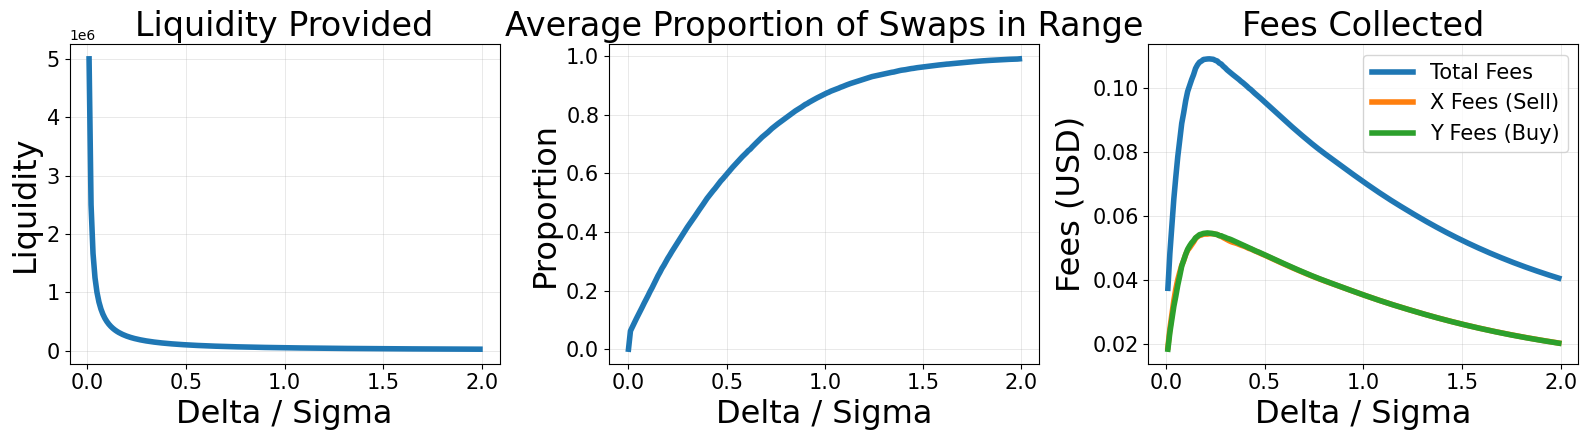

In [59]:
fig, ax = plt.subplots(1,3,figsize=(16,4.5))
ax[0].plot((np.array(deltas)-1)/sigma, Ls, lw=4)
ax[0].set_title("Liquidity Provided", fontsize=24)
ax[0].set_xlabel("Delta / Sigma", fontsize=15)
ax[0].set_ylabel("Liquidity", fontsize=15)

ax[1].plot((np.array(deltas)-1)/sigma, avg_range_swaps, lw=4);
ax[1].set_title("Average Proportion of Swaps in Range", fontsize=24)
ax[1].set_xlabel("Delta / Sigma", fontsize=15)
ax[1].set_ylabel("Proportion", fontsize=15)
# ax[0].set_ylim(0,0.7)
# ax[0].axvline(x = 1-pa, linestyle='--')
# ax[0].axvline(x = 1-pb, linestyle='--')
ax[2].plot((np.array(deltas)-1)/sigma, np.stack(avg_fees), lw=4);
ax[2].legend(labels = ["Total Fees", "X Fees (Sell)", "Y Fees (Buy)"], fontsize=15)
# ax[1].axvline(x = 1-pa, linestyle='--')
# ax[1].axvline(x = 1-pb, linestyle='--')
ax[2].set_title("Fees Collected", fontsize=24)
ax[2].set_xlabel("Delta / Sigma", fontsize=15)
ax[2].set_ylabel("Fees (USD)", fontsize=15)

for i in range(3):
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)
fig.tight_layout()


#### Changing the Drift & Looking at Fees Earnt (for fixed, symmetric range)

In [60]:
deltas = [1+0.00005*i for i in range(1,200)]

shifts = [0, 0.5*sigma, sigma, 2*sigma]
alphas = [0., 0.2*sigma, 0.4*sigma]

dollars = 100
alpha = 0.
sigma = 0.002

pnls = np.zeros((len(shifts),len(deltas),len(alphas)))

for alpha_idx in range(len(alphas)):
    alpha = alphas[alpha_idx]
    
    paths, P_T = sim_asset_swap_paths(num_sims = 1000, alpha=alpha, sigma=sigma)

    for shift_idx in range(len(shifts)):
        shift = shifts[shift_idx]

        for delta_idx in range(len(deltas)):
            delta = deltas[delta_idx]

            pa = 1/delta + shift
            pb = 1*delta + shift
            
            some_fees = []
            num_swaps_in_range = []
            total_swaps = []

            for path in paths:
                some_fees.append(feesEarned(path[:,-1], dollars, pa, pb)[0])

            pnls[shift_idx, delta_idx, alpha_idx] = np.mean(some_fees)

TypeError: list indices must be integers or slices, not tuple

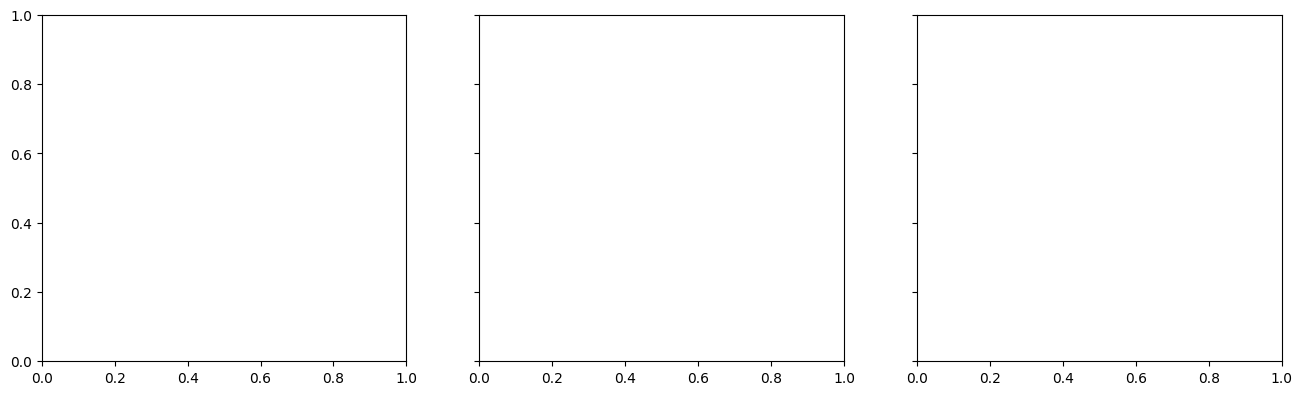

In [87]:
fig, ax = plt.subplots(1,3,figsize=(16,4.5), sharey=True, sharex=True)

for i in range(3):
    ax[i].plot((np.array(deltas)-1)/sigma, pnls[:,:,i].T, lw=4);
    ax[i].legend(labels = [f"Shift = {shifts[j]}" for j in range(len(shifts))], fontsize=15)
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)
    ax[i].set_title(f"Fees Collected for Alpha = {alphas[i]}", fontsize=24)
    ax[i].set_xlabel("Delta / Sigma", fontsize=15)
    ax[i].set_ylabel("Fees (USD)", fontsize=15)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
fig.tight_layout()


#### Fix $\alpha = 0, \sigma = 0.002$

In [89]:
deltas = [1+0.00002*i for i in range(200)]

dollars = 100
alpha = 0.
sigma = 0.002

Lp_vals = []
initial_vals = []
final_vals = []

paths, P_T = sim_asset_swap_paths(num_sims = 1000, alpha=alpha, sigma=sigma)

for delta in deltas:

    pa = 1/delta
    pb = 1*delta
    
    vals = []
    initial_V = []
    final_V = []

    L = calculate_liquidity(dollars, pa, pb)

    for path in paths:
        IL, V0, VT = LP_value(path[:,-1], dollars, pa, pb)

        vals.append(IL)
        initial_V.append(V0)
        final_V.append(VT)

    Lp_vals.append(np.array(vals))
    initial_vals.append(np.array(initial_V))
    final_vals.append(np.array(final_V))

/tmp/ipykernel_185310/298828163.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  L = (dollars_invested/p0) *(np.sqrt(pa*pb)) / (np.sqrt(pb) - np.sqrt(pa))
/tmp/ipykernel_185310/6466658.py:54: RuntimeWarning: invalid value encountered in scalar multiply
  V0 = L*(1/np.sqrt(pa) - 1/np.sqrt(pb))*prices[0]
/tmp/ipykernel_185310/6466658.py:61: RuntimeWarning: invalid value encountered in scalar multiply
  VT = L*(1/np.sqrt(pa) - 1/np.sqrt(pb))*prices[-1]
/tmp/ipykernel_185310/6466658.py:63: RuntimeWarning: invalid value encountered in scalar multiply
  VT = L*(np.sqrt(pb) - np.sqrt(pa))


In [90]:
IL_VT_vals = np.c_[P_T ,np.stack(final_vals)[-1]]
IL_VT_vals = IL_VT_vals[np.argsort(IL_VT_vals[:,1])]

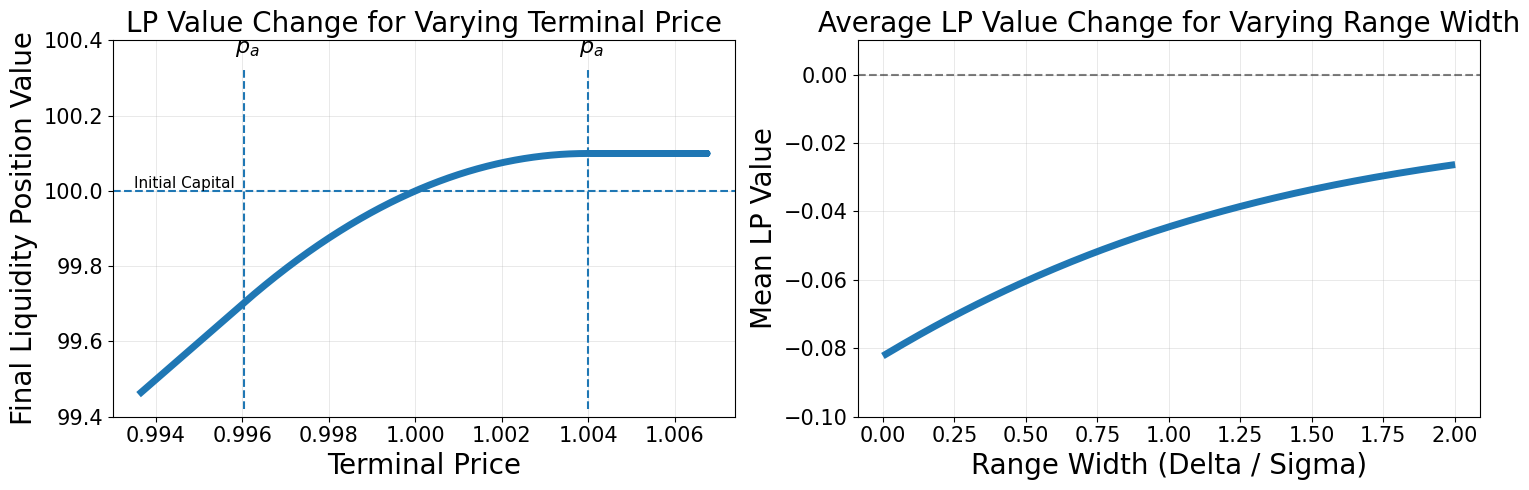

In [92]:
# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Left subplot: Scatter plot and dashed lines
ax[0].set_title("LP Value Change for Varying Terminal Price", fontsize=20)
ax[0].plot(IL_VT_vals[:,0] ,IL_VT_vals[:,1], label='Final Liquidity Position Value', lw=5)
ax[0].axhline(y=100, linestyle='--', label='Initial Capital')
ax[0].axvline(x=pa, ymin=0.02, ymax=0.93, linestyle='--', label=r'$p_a$')
ax[0].axvline(x=pb, ymin=0.02, ymax=0.93, linestyle='--', label=r'$p_b$')
ax[0].set_ylim(99.4, 100.4)
ax[0].set_xlabel("Terminal Price", fontsize=16)
ax[0].set_ylabel("Final Liquidity Position Value", fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
# ax[0].legend(loc='upper left')

# Add labels next to dashed lines
ax[0].text(pa-0.0002, 100.35, r'$p_a$', verticalalignment='bottom', fontsize=16)
ax[0].text(pb-0.0002, 100.35, r'$p_a$', verticalalignment='bottom', fontsize=16)
ax[0].text(0.9935, 100, 'Initial Capital', verticalalignment='bottom', fontsize=11)

# Right subplot: Line plot
ax[1].set_title("Average LP Value Change for Varying Range Width", fontsize=20)
ax[1].plot((np.array(deltas)-1)/sigma, np.stack(Lp_vals).mean(axis=1), lw=5)
ax[1].set_ylabel('Mean LP Value', fontsize=16)
ax[1].set_xlabel('Range Width (Delta / Sigma)', fontsize=16)
# ax[1].legend(loc='upper right', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].set_ylim(-0.1,0.01)
ax[1].axhline(y=0, linestyle='--', color='black', alpha=0.5)

for i in range(2):
    ax[i].yaxis.label.set_size(20)
    ax[i].xaxis.label.set_size(20)
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)
fig.tight_layout()

In [93]:
scale = (100 - IL_VT_vals[0,1])/(pb - IL_VT_vals[0,0])

put_vals = np.clip(pb - IL_VT_vals[:,0], 0, 9999)

hedged_port = put_vals*scale + IL_VT_vals[:,1]

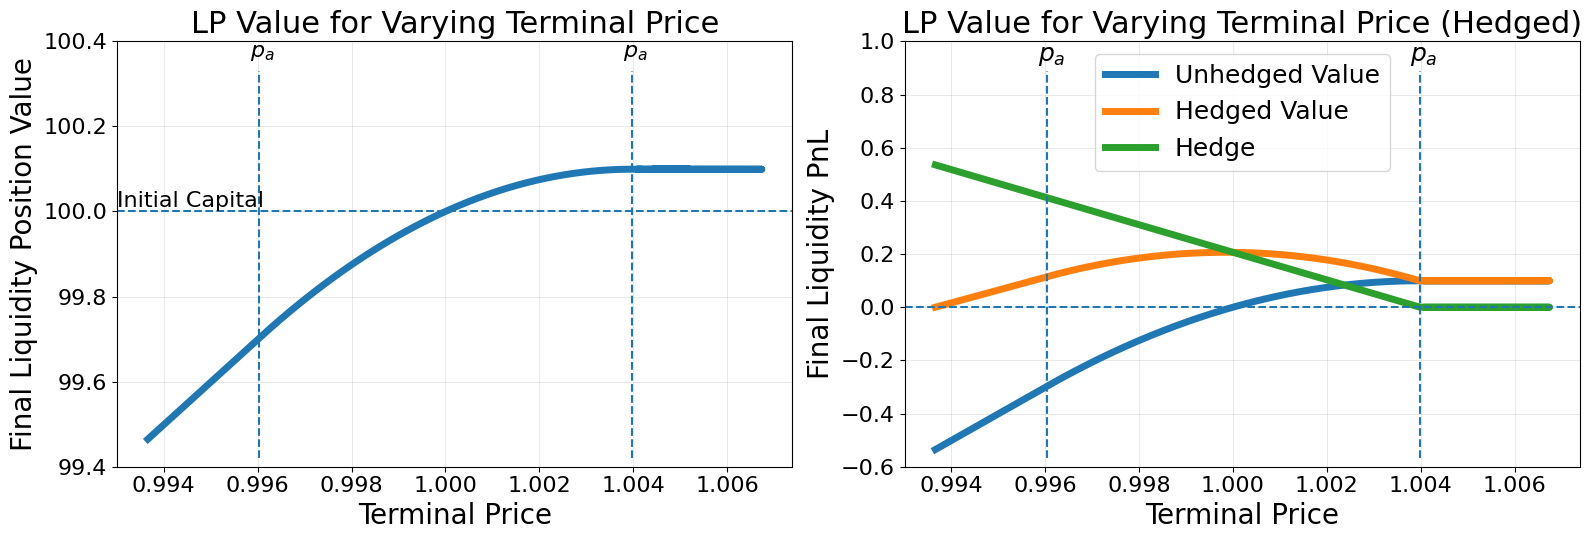

In [94]:


# Create figure and subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 5.5))

# Left subplot: Scatter plot and dashed lines
ax[0].set_title("LP Value for Varying Terminal Price", fontsize=22)
ax[0].plot(IL_VT_vals[:,0] ,IL_VT_vals[:,1], label='Final Liquidity Position Value', lw=5)
ax[0].axhline(y=100, linestyle='--', label='Initial Capital')
ax[0].axvline(x=pa, ymin=0.02, ymax=0.93, linestyle='--', label=r'$p_a$')
ax[0].axvline(x=pb, ymin=0.02, ymax=0.93, linestyle='--', label=r'$p_b$')
ax[0].set_ylim(99.4, 100.4)
ax[0].set_xlabel("Terminal Price", fontsize=16)
ax[0].set_ylabel("Final Liquidity Position Value", fontsize=16)
ax[0].tick_params(axis='both', which='major', labelsize=14)
# ax[0].legend(loc='upper left')

# Add labels next to dashed lines
ax[0].text(pa-0.0002, 100.35, r'$p_a$', verticalalignment='bottom', fontsize=16)
ax[0].text(pb-0.0002, 100.35, r'$p_a$', verticalalignment='bottom', fontsize=16)
ax[0].text(0.993, 100, 'Initial Capital', verticalalignment='bottom', fontsize=16)

# Left subplot: Scatter plot and dashed lines
ax[1].set_title("LP Value for Varying Terminal Price (Hedged)", fontsize=22)
ax[1].plot(IL_VT_vals[:,0] ,IL_VT_vals[:,1]-100, label = "Unhedged Value", lw=5)
ax[1].plot(IL_VT_vals[:,0], hedged_port-100, label = "Hedged Value", lw=5)
ax[1].plot(IL_VT_vals[:,0], put_vals*scale, label = "Hedge", lw=5)
ax[1].axhline(y=0, linestyle='--')
ax[1].axvline(x=pa, ymin=0.02, ymax=0.93, linestyle='--')
ax[1].axvline(x=pb, ymin=0.02, ymax=0.93, linestyle='--')
ax[1].set_ylim(-0.6, 1)
ax[1].set_xlabel("Terminal Price", fontsize=16)
ax[1].set_ylabel("Final Liquidity PnL", fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[1].legend(loc='best', fontsize=18)

# Add labels next to dashed lines
ax[1].text(pa-0.0002, 0.9, r'$p_a$', verticalalignment='bottom', fontsize=18)
ax[1].text(pb-0.0002, 0.9, r'$p_a$', verticalalignment='bottom', fontsize=18)
# ax[1].text(0.993, 100, 'Initial Capital', verticalalignment='bottom', fontsize=16)

for i in range(2):
    ax[i].yaxis.label.set_size(20)
    ax[i].xaxis.label.set_size(20)
    ax[i].tick_params(axis='x', labelsize=16)
    ax[i].tick_params(axis='y', labelsize=16)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)
fig.tight_layout()

Impermanent Loss with Non zero drift

In [101]:
deltas = [1+0.00005*i for i in range(1,200)]

shifts = [0, 0.5*sigma, sigma, 2*sigma]
alphas = [0., 0.2*sigma, 0.4*sigma]

dollars = 100
alpha = 0.
sigma = 0.002

ILs = np.zeros((len(shifts),len(deltas),len(alphas)))

for alpha_idx in range(len(alphas)):
    alpha = alphas[alpha_idx]
    
    paths, P_T = sim_asset_swap_paths(num_sims = 1000, alpha=alpha, sigma=sigma)

    for shift_idx in range(len(shifts)):
        shift = shifts[shift_idx]

        for delta_idx in range(len(deltas)):
            delta = deltas[delta_idx]

            pa = 1/delta + shift
            pb = 1*delta + shift
            
            ImPLs = []

            for path in paths:
                IL, V0, VT = LP_value(path[:,-1], dollars, pa, pb)
                ImPLs.append(IL)

            ILs[shift_idx, delta_idx, alpha_idx] = np.mean(ImPLs)

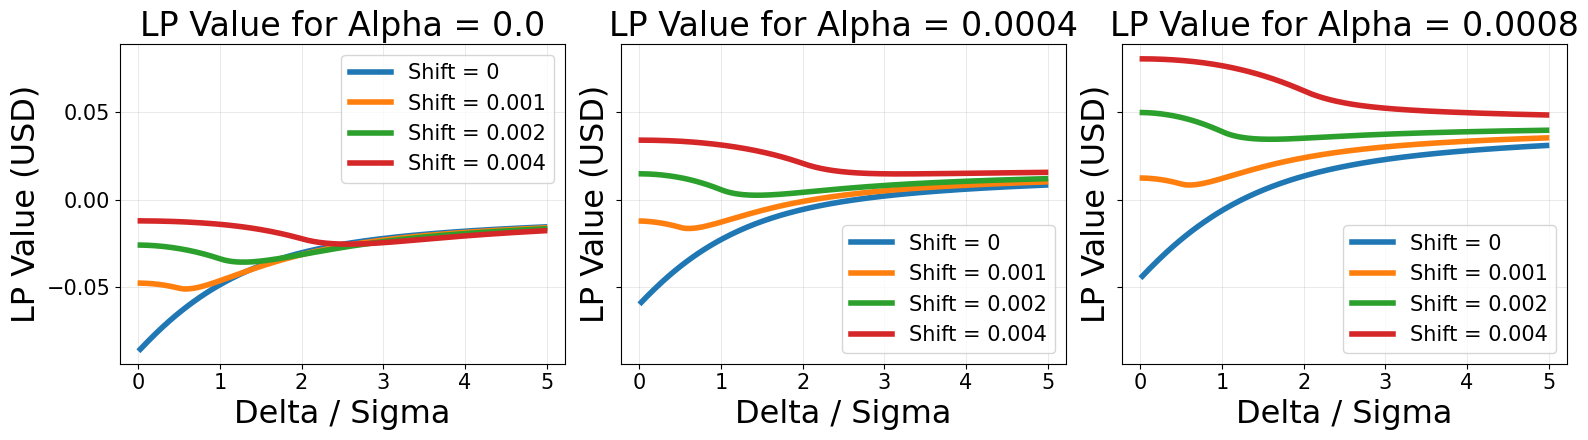

In [70]:
fig, ax = plt.subplots(1,3,figsize=(16,4.5), sharey=True, sharex=True)

for i in range(3):
    ax[i].plot((np.array(deltas)-1)/sigma, ILs[:,:,i].T, lw=4);
    ax[i].legend(labels = [f"Shift = {shifts[j]}" for j in range(len(shifts))], fontsize=15)
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)
    ax[i].set_title(f"LP Value for Alpha = {alphas[i]}", fontsize=24)
    ax[i].set_xlabel("Delta / Sigma", fontsize=15)
    ax[i].set_ylabel("LP Value (USD)", fontsize=15)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
fig.tight_layout()

Overall Portfolio

In [103]:
deltas = [1+0.00005*i for i in range(1,200)]

shifts = [0, 0.5*sigma, sigma, 2*sigma]
alphas = [0., 0.2*sigma, 0.4*sigma]

dollars = 100
alpha = 0.
sigma = 0.002

pnls = np.zeros((len(shifts),len(deltas),len(alphas)))

for alpha_idx in range(len(alphas)):
    alpha = alphas[alpha_idx]
    
    paths, P_T = sim_asset_swap_paths(num_sims = 1000, alpha=alpha, sigma=sigma)

    for shift_idx in range(len(shifts)):
        shift = shifts[shift_idx]

        for delta_idx in range(len(deltas)):
            delta = deltas[delta_idx]

            pa = 1/delta + shift
            pb = 1*delta + shift
            
            some_fees = []
            num_swaps_in_range = []
            total_swaps = []

            for path in paths:
                some_fees.append(feesEarned(path[:,-1], dollars, pa, pb)[0])

            pnls[shift_idx, delta_idx, alpha_idx] = np.mean(some_fees)

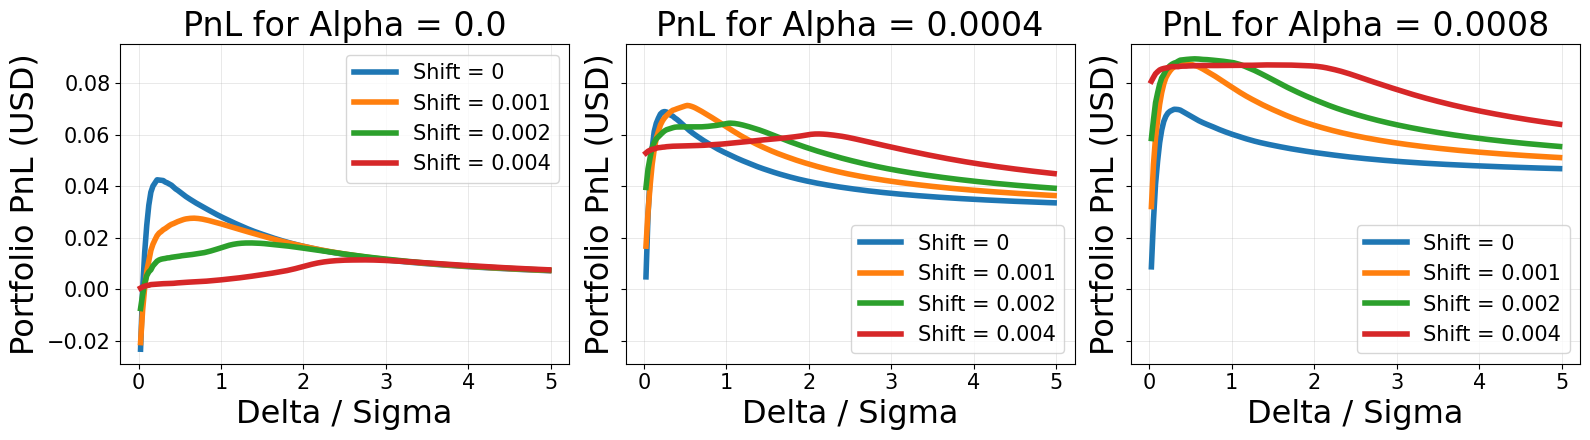

In [104]:
fig, ax = plt.subplots(1,3,figsize=(16,4.5), sharey=True, sharex=True)

for i in range(3):
    ax[i].plot((np.array(deltas)-1)/sigma, (pnls + ILs)[:,:,i].T, lw=4);
    ax[i].legend(labels = [f"Shift = {shifts[j]}" for j in range(len(shifts))], fontsize=15)
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].tick_params(axis='y', labelsize=15)
    # ax[i].legend(fontsize=20)
    ax[i].grid(alpha=0.4, linewidth=.5)
    ax[i].set_title(f"PnL for Alpha = {alphas[i]}", fontsize=24)
    ax[i].set_xlabel("Delta / Sigma", fontsize=15)
    ax[i].set_ylabel("Portfolio PnL (USD)", fontsize=15)
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
fig.tight_layout()

PnL for varying range widths with zero drift

In [95]:
deltas = [1+0.00002*i for i in range(200)]

dollars = 100
alpha = 0.
sigma = 0.002

Lp_vals = []
avg_fees = []
pnls = []

paths, P_T = sim_asset_swap_paths(num_sims = 1000, alpha=alpha, sigma=sigma)

for delta in deltas:

    pa = 1/delta
    pb = 1*delta
    
    vals = []
    some_fees = []
    curr_pnl = []

    L = calculate_liquidity(dollars, pa, pb)

    for path in paths:
        IL, V0, VT = LP_value(path[:,-1], dollars, pa, pb)
        fee = feesEarned(path[:,-1], dollars, pa, pb)
        
        some_fees.append(fee)
        vals.append(IL)
        curr_pnl.append(fee[0]+IL)

    Lp_vals.append(np.array(vals))
    some_fees = np.array(some_fees)
    avg_fees.append(np.array(some_fees).mean(axis=0))
    pnls.append(np.array(curr_pnl))

/tmp/ipykernel_185310/298828163.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  L = (dollars_invested/p0) *(np.sqrt(pa*pb)) / (np.sqrt(pb) - np.sqrt(pa))
/tmp/ipykernel_185310/6466658.py:54: RuntimeWarning: invalid value encountered in scalar multiply
  V0 = L*(1/np.sqrt(pa) - 1/np.sqrt(pb))*prices[0]
/tmp/ipykernel_185310/6466658.py:61: RuntimeWarning: invalid value encountered in scalar multiply
  VT = L*(1/np.sqrt(pa) - 1/np.sqrt(pb))*prices[-1]
/tmp/ipykernel_185310/6466658.py:63: RuntimeWarning: invalid value encountered in scalar multiply
  VT = L*(np.sqrt(pb) - np.sqrt(pa))


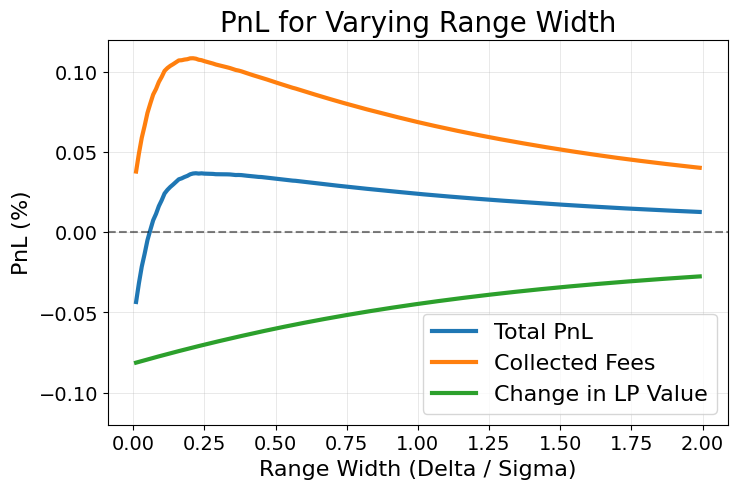

In [96]:
fig, ax = plt.subplots(figsize=(8,5))

ax.plot((np.array(deltas)-1)/sigma, np.stack(pnls).mean(axis=1), label = "Total PnL", lw=3)
ax.plot((np.array(deltas)-1)/sigma, np.stack(avg_fees)[:,0], label = "Collected Fees", lw=3)
ax.plot((np.array(deltas)-1)/sigma, np.stack(Lp_vals).mean(axis=1), label = "Change in LP Value", lw=3)
ax.set_title("PnL for Varying Range Width", fontsize=20)
ax.set_xlabel("Range Width (Delta / Sigma)", fontsize=16)
ax.set_ylabel("PnL " + r'$(\%)$', fontsize=16)
ax.set_ylim(-0.12,0.12)
ax.axhline(y=0, linestyle='--', color='black', alpha=0.5)

ax.yaxis.label.set_size(16)
ax.xaxis.label.set_size(16)
ax.tick_params(axis='x', labelsize=14)
ax.tick_params(axis='y', labelsize=14)
ax.legend(fontsize=16)
ax.grid(alpha=0.4, linewidth=.5)

## Optimisation


In [74]:
def fee_objective(pa_pb, paths, dollars):
    pa, pb = pa_pb
    # pa, pb = 1/delta, 1*delta
    fees = []
    
    for path in paths:
        fee, _, _ = feesEarned(path[:,-1], dollars, pa, pb)
        
        fees.append(fee)

    return -np.mean(fees)  # Minimize negative of mean PNLs

def IL_objective(pa_pb, paths, dollars):
    pa, pb = pa_pb
    # pa, pb = 1/delta, 1*delta
    vals = []
    
    for path in paths:
        IL, _, _ = LP_value(path[:,-1], dollars, pa, pb)
        
        vals.append(IL)

    return -np.mean(vals)  # Minimize negative of mean PNLs

In [75]:
def objective1(pa_pb, paths, dollars):
    pa, pb = pa_pb
    # pa, pb = 1/delta, 1*delta
    fees = []
    ILs = []
    pnls = []
    
    for path in paths:
        IL, _, _ = LP_value(path[:,-1], dollars, pa, pb)
        fee, _, _ = feesEarned(path[:,-1], dollars, pa, pb)
        
        fees.append(fee)
        ILs.append(IL)

        pnls.append(fee + IL)

    return -np.mean(pnls)  # Minimize negative of mean PNLs

def objective2(delta_shift, paths, dollars):
    delta, mu = delta_shift
    pa = 1/delta + mu
    pb = 1*delta + mu
    fees = []
    ILs = []
    pnls = []
    
    for path in paths:
        IL, _, _ = LP_value(path[:,-1], dollars, pa, pb)
        fee, _, _ = feesEarned(path[:,-1], dollars, pa, pb)
        
        fees.append(fee)
        ILs.append(IL)

        pnls.append(fee + IL)

    return -np.mean(pnls)  # Minimize negative of mean PNLs

def mean_var_objective(pa_pb, paths, dollars, risk_aversion):
    pa, pb = pa_pb
    # pa, pb = 1/delta, 1*delta
    fees = []
    ILs = []
    pnls = []
    
    for path in paths:
        IL, _, _ = LP_value(path[:,-1], dollars, pa, pb)
        fee, _, _ = feesEarned(path[:,-1], dollars, pa, pb)
        
        fees.append(fee)
        ILs.append(IL)

        pnls.append(fee + IL)

    return -np.mean(pnls) + risk_aversion*np.var(pnls)  # Minimize negative of mean PNLs

#### Changing $p_a, p_b$ instead of $\delta$

In [76]:
from tqdm import tqdm

In [77]:
dollars = 100
sigma = 0.002
alphas = [0., 0.2*sigma, 0.4*sigma]

pa_vals = [1-i*sigma/4 for i in range(1,40)]
pb_vals = [1+i*sigma/4 for i in range(1,40)]

objs = np.zeros((len(pa_vals), len(pb_vals), len(alphas)))
fee_objs = np.zeros((len(pa_vals), len(pb_vals), len(alphas)))
IL_objs = np.zeros((len(pa_vals), len(pb_vals), len(alphas)))

for alpha_idx in tqdm(range(len(alphas))):
    alpha = alphas[alpha_idx]
    paths, P_T = sim_asset_swap_paths(num_sims=1000, alpha=alpha, sigma=sigma)
    
    # Loop over pa and pb values
    for pa_idx in tqdm(range(len(pa_vals))):
        pa = pa_vals[pa_idx]
        for pb_idx in range(len(pb_vals)):
            pb = pb_vals[pb_idx]
            # Convert pa, pb, and alpha to indices
            
            # Compute the objective and store it in the objs array

            fee_objs[pa_idx, pb_idx, alpha_idx] = -fee_objective([pa, pb], paths, dollars)
            IL_objs[pa_idx, pb_idx, alpha_idx] = -IL_objective([pa, pb], paths, dollars)

            objs[pa_idx, pb_idx, alpha_idx] = -objective1([pa, pb], paths, dollars)

100%|██████████| 3/3 [10:00<00:00, 200.11s/it]


In [78]:
rel_pa_vals = (np.array(pa_vals)-1)/sigma
rel_pb_vals = (np.array(pb_vals)-1)/sigma

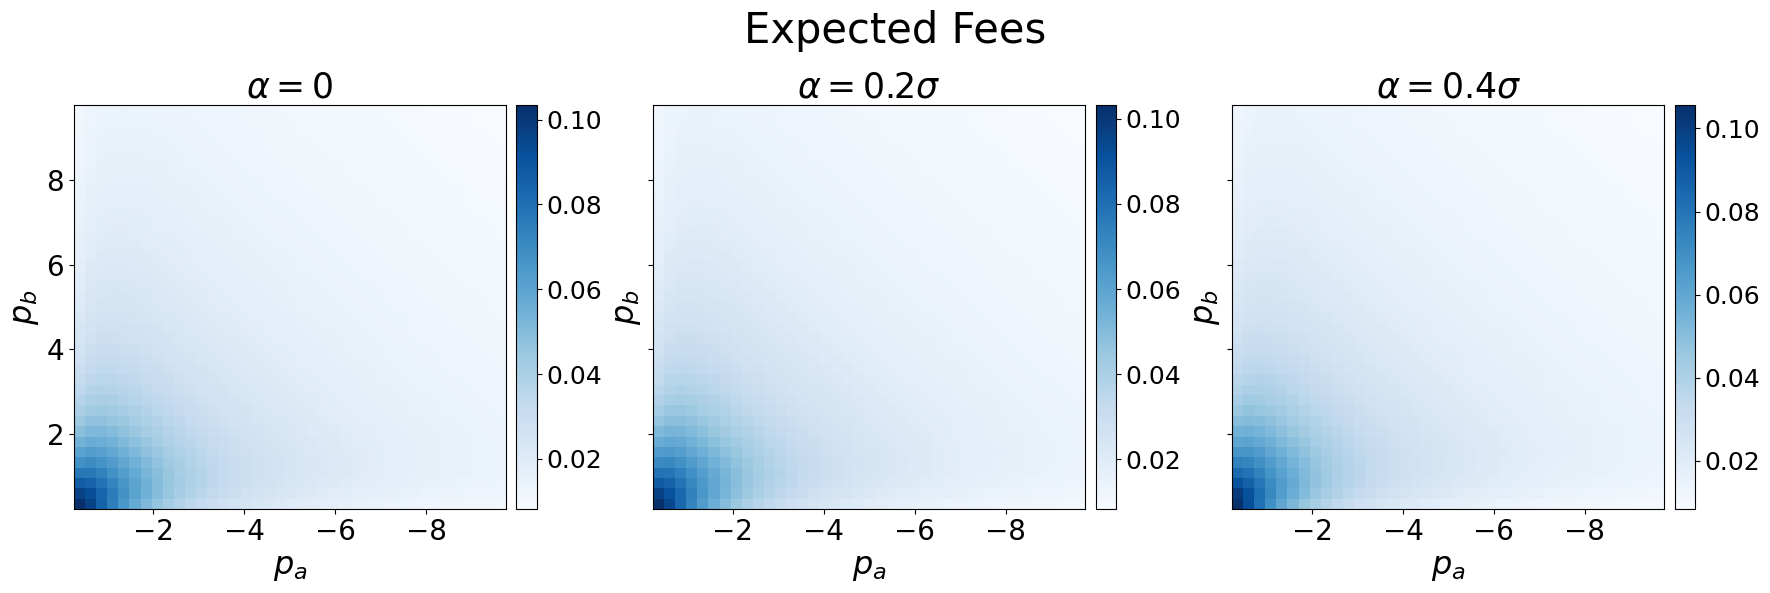

In [79]:
from matplotlib import font_manager

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

titles = [r'$\alpha=0$', r'$\alpha=0.2\sigma$', r'$\alpha=0.4\sigma$']
for i in range(3):
    im = ax[i].imshow(fee_objs[:, :, i].T, origin='lower', aspect='auto', cmap='Blues',
                       extent=[rel_pa_vals[0], rel_pa_vals[-1], rel_pb_vals[0], rel_pb_vals[-1]])
    ax[i].set_title(titles[i], fontsize=25)
    ax[i].set_xlabel(r'$p_a$')
    ax[i].set_ylabel(r'$p_b$')
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    cbar = fig.colorbar(im, ax=ax[i], pad=0.02)
    
    # Set font properties for the colorbar
    font = font_manager.FontProperties(size=18)  # Adjust the size as needed
    cbar.ax.yaxis.set_tick_params(labelsize=18)
    cbar.ax.yaxis.set_tick_params(labelsize=18)
fig.suptitle('Expected Fees', fontsize=30)
# Show the plot
plt.tight_layout(w_pad=-0.7)

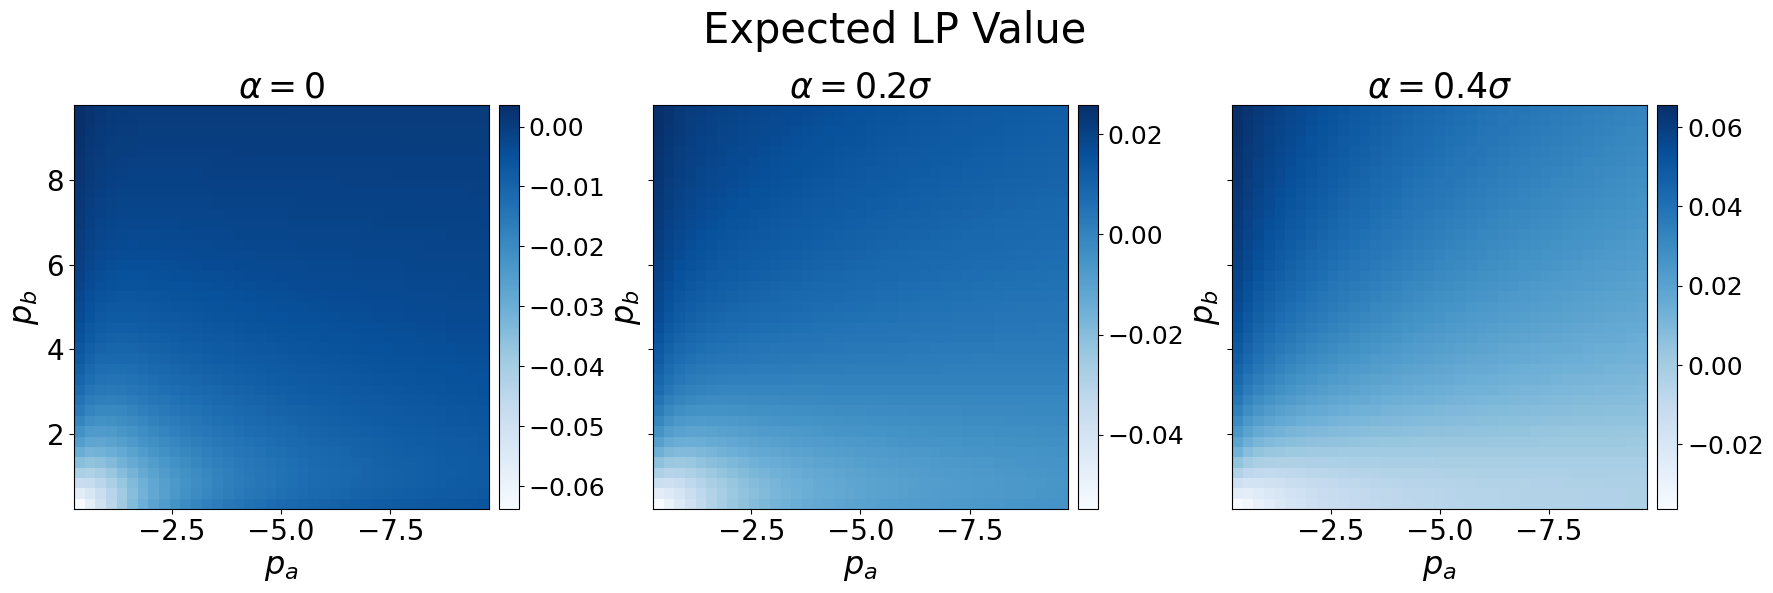

In [80]:
from matplotlib import font_manager

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

titles = [r'$\alpha=0$', r'$\alpha=0.2\sigma$', r'$\alpha=0.4\sigma$']
for i in range(3):
    im = ax[i].imshow(IL_objs[:, :, i].T, origin='lower', aspect='auto', cmap='Blues',
                       extent=[rel_pa_vals[0], rel_pa_vals[-1], rel_pb_vals[0], rel_pb_vals[-1]])
    ax[i].set_title(titles[i], fontsize=25)
    ax[i].set_xlabel(r'$p_a$')
    ax[i].set_ylabel(r'$p_b$')
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    cbar = fig.colorbar(im, ax=ax[i], pad=0.02)
    
    # Set font properties for the colorbar
    font = font_manager.FontProperties(size=18)  # Adjust the size as needed
    cbar.ax.yaxis.set_tick_params(labelsize=18)
    cbar.ax.yaxis.set_tick_params(labelsize=18)
fig.suptitle('Expected LP Value', fontsize=30)
# Show the plot
plt.tight_layout(w_pad=-0.7)

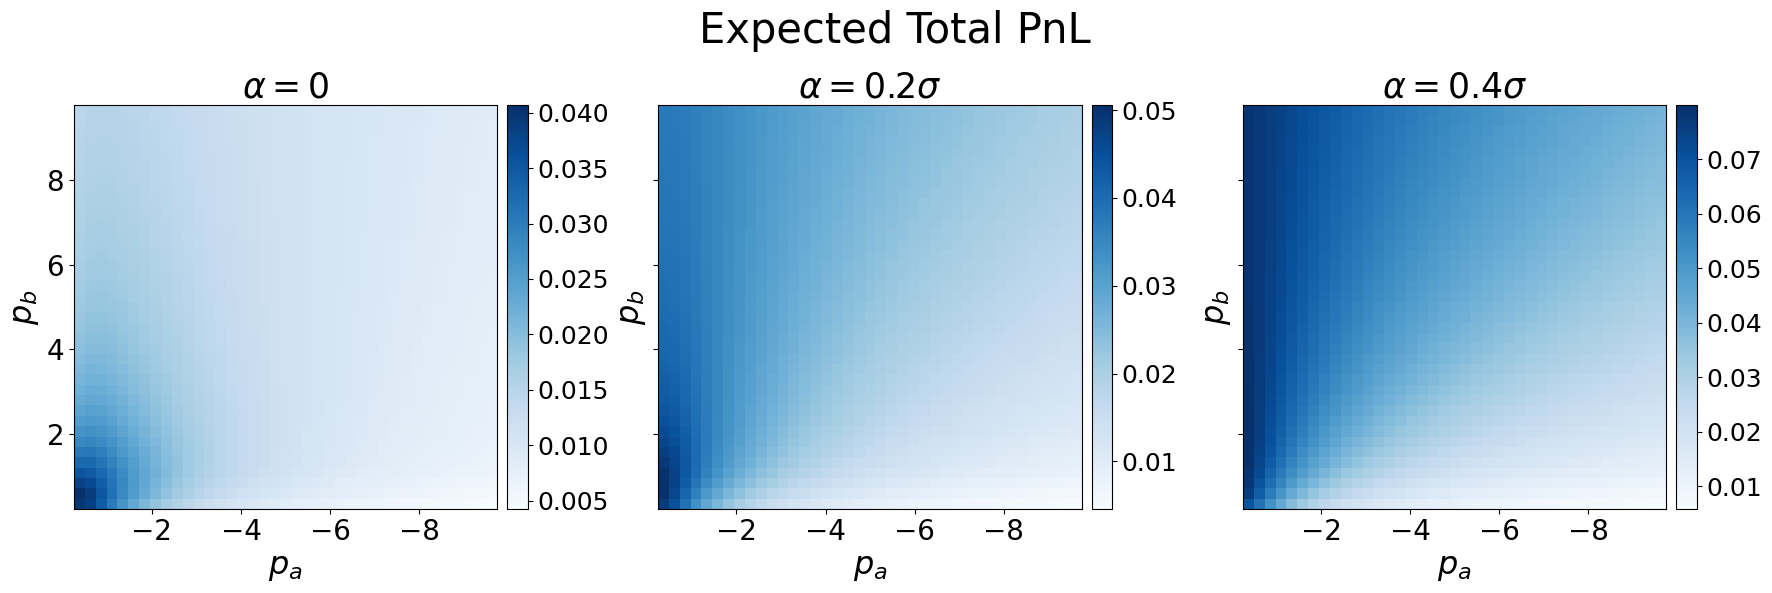

In [81]:
from matplotlib import font_manager

fig, ax = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)

titles = [r'$\alpha=0$', r'$\alpha=0.2\sigma$', r'$\alpha=0.4\sigma$']
for i in range(3):
    im = ax[i].imshow(objs[:, :, i].T, origin='lower', aspect='auto', cmap='Blues',
                       extent=[rel_pa_vals[0], rel_pa_vals[-1], rel_pb_vals[0], rel_pb_vals[-1]])
    ax[i].set_title(titles[i], fontsize=25)
    ax[i].set_xlabel(r'$p_a$')
    ax[i].set_ylabel(r'$p_b$')
    ax[i].yaxis.label.set_size(23)
    ax[i].xaxis.label.set_size(23)
    ax[i].tick_params(axis='x', labelsize=20)
    ax[i].tick_params(axis='y', labelsize=20)
    cbar = fig.colorbar(im, ax=ax[i], pad=0.02)
    
    # Set font properties for the colorbar
    font = font_manager.FontProperties(size=18)  # Adjust the size as needed
    cbar.ax.yaxis.set_tick_params(labelsize=18)
    cbar.ax.yaxis.set_tick_params(labelsize=18)

fig.suptitle('Expected Total PnL', fontsize=30)
# Show the plot
plt.tight_layout(w_pad=-0.7)

In [84]:
print(f"Optimal pa, pb: {rel_pa_vals[np.unravel_index(objs.argmax(), objs.shape)[0]]:.4f}, {rel_pb_vals[np.unravel_index(objs.argmax(), objs.shape)[1]]:.4f}")

Optimal pa, pb: -0.2500, 1.7500


### Optimising For $p_a, p_b$

In [82]:
from scipy.optimize import minimize

alpha = 0.
sigma = 0.002

paths, P_T = sim_asset_swap_paths(num_sims = 100000, alpha=alpha, sigma=sigma)

initial_guess = [1-0.5*sigma, 1+0.5*sigma]

constraints1 = ({'type': 'ineq', 'fun': lambda x: x[0]},  # pa > 0
            {'type': 'ineq', 'fun': lambda x: x[1]},  # pb > 0
            {'type': 'ineq', 'fun': lambda x: x[1] - x[0]})  # pb > pa

result = minimize(objective1, initial_guess, args=(paths, dollars), method='SLSQP', constraints=constraints1)

optimal_pa, optimal_pb = result.x

In [83]:
# optimal_delta = result.x
# print("Optimal Delta:", optimal_delta)

optimal_pa, optimal_pb = result.x
print(f"Optimal pa (n sigma): {(optimal_pa-1)/sigma:.4f}")
print(f"Optimal pb (n sigma): {(optimal_pb-1)/sigma:.4f}")
print(f"Max PnL: {-result.fun:.4f}")

Optimal pa (n sigma): -0.0493
Optimal pb (n sigma): -0.0493
Max PnL: 0.1034
